In [56]:
! pip install --quiet efficientnet

https://www.kaggle.com/code/pulkit12dhingra/cat-dog-audio-classification

## Import Data

In [1]:
# importing all the modules
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn 
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import librosa

In [2]:
# setting up the data directory
DATA_DIR="cats_dogs/"

# setting up path for train and test data
train_dir=DATA_DIR+"/train"
test_dir=DATA_DIR+"/test"

In [3]:
# get the train files
file_train = tf.io.gfile.glob(train_dir + '/*/*')
# shuffle 
file_train = tf.random.shuffle(file_train)

train_ds=file_train

# get the test files
file_test = tf.io.gfile.glob(test_dir + '/*/*')
# shuffle 
file_test = tf.random.shuffle(file_test)


test_ds=file_test
print("Shape of train data:- ", train_ds.shape)
print("Shape of test data:- ",file_test.shape)

Shape of train data:-  (210,)
Shape of test data:-  (67,)


In [6]:
# Function to get waveform and it's label
def get_waveform_label(file):
  # get the label
  lab = tf.strings.split(file, os.path.sep)[-2]
  # read the binalry file 
  y, sr = librosa.load("cats_dogs/cat_1.wav")
  return y, lab

# get waveforms and labels of all files
AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'samplerate'

This error is lazily reported, having originally occured in
  File c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\audio.py, line 31, in <module>

----> samplerate = lazy.load("samplerate")
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'samplerate'

This error is lazily reported, having originally occured in
  File c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\audio.py, line 31, in <module>

----> samplerate = lazy.load("samplerate")
To silence this warning, decorate the function with @tf.

In [67]:
# Function to get waveform and it's label
def get_waveform_label(file):
  # get the label
  lab = tf.strings.split(file, os.path.sep)[-2]
  # read the binalry file 
  audio_binary = tf.io.read_file(file)
  # decode the file 
  audio, _ = tf.audio.decode_wav(audio_binary)
  # sqeeze tha audio
  waveform=tf.squeeze(audio, axis=-1)
  return waveform, lab

# get waveforms and labels of all files
AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

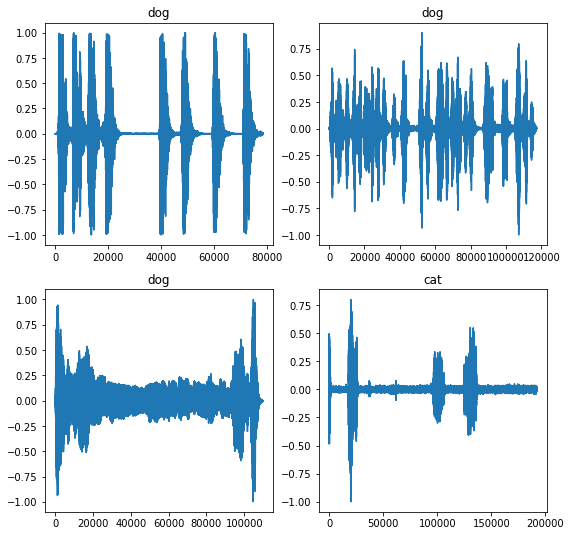

In [72]:
# number of rows and columns of plot
row,col = 2,2
n = row*col
fig, axs = plt.subplots(row, col, figsize=(9, 9))

# plotting waveforms
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // col
  c = i % col
  ax = axs[r][c]
  ax.plot(audio.numpy())

  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [102]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [104]:
get_melspectrogram_db("cats_dogs/cat_10.wav")

TypeError: melspectrogram() takes 0 positional arguments but 1 positional argument (and 3 keyword-only arguments) were given

In [100]:
# function to get the spectogram and the labels
def get_spectrogram_label(audio, label):
  # apply padding
  padding = tf.zeros([300000] - tf.shape(audio), dtype=tf.float32)
  # get the spectogram of the audio
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(
      eq_length, frame_length=210, frame_step=110)    
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # get associated label of the audio
  label_id = tf.argmax(label == labels)
  # return the spectogram and the label
  return spectrogram, label_id

# get all the labels from the dataset   
labels = np.array(["cat","dog"])

# get the labels and spectogram
spectrogram_ds = waveform_ds.map(
    get_spectrogram_label, num_parallel_calls=AUTO)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


C:\Users\moham\AppData\Local\Temp\ipykernel_36480\1159814392.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


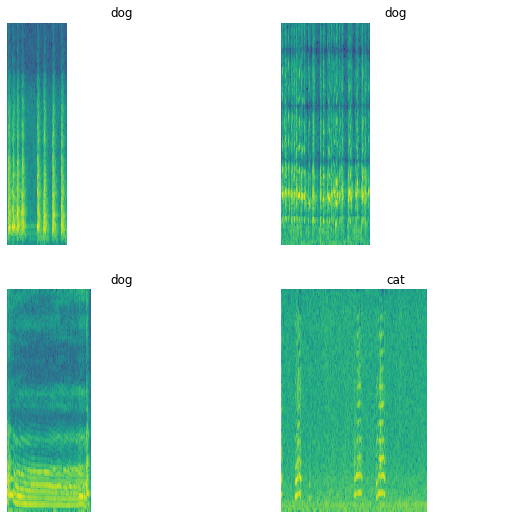

In [75]:
# function to plot the spectogram
def plot_spect(spectrogram, ax):
  # Converting frequencies to log and transpose to repesent time on x axis
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# plot using a subplot
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # function call
  plot_spect(np.squeeze(spectrogram.numpy()), ax)
  # set the title label
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')
plt.show()

In [76]:
# function to preprocess the data
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  # get waveforms and labels
  output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)
  # get spectogram and labels
  output_ds = output_ds.map(
      get_spectrogram_label,  num_parallel_calls=AUTO)
 # return the data
  return output_ds

# train test and validate data
train_ds = spectrogram_ds

test_ds = preprocess(test_ds)

## Model

In [77]:
# initialize a batch size
batch_size = 64
# batch train and validate data
train_ds = train_ds.batch(batch_size)
# cache and prefetch the data
train_ds = train_ds.cache().prefetch(AUTO)

In [78]:
# building the model
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)
# normalize adapt 
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# adding layers
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (2726, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                          

In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [80]:
EPOCHS = 15
history = model.fit(
    train_ds,  
    epochs=EPOCHS,
)

Epoch 1/15
4/4 [==============================] - 3s 268ms/step - loss: 0.7069 - accuracy: 0.6190
Epoch 2/15
4/4 [==============================] - 0s 96ms/step - loss: 0.5803 - accuracy: 0.7810
Epoch 3/15
4/4 [==============================] - 0s 92ms/step - loss: 0.5189 - accuracy: 0.8000
Epoch 4/15
4/4 [==============================] - 0s 100ms/step - loss: 0.4841 - accuracy: 0.7857
Epoch 5/15
4/4 [==============================] - 0s 91ms/step - loss: 0.4215 - accuracy: 0.8571
Epoch 6/15
4/4 [==============================] - 0s 91ms/step - loss: 0.3744 - accuracy: 0.8476
Epoch 7/15
4/4 [==============================] - 0s 90ms/step - loss: 0.3706 - accuracy: 0.8381
Epoch 8/15
4/4 [==============================] - 0s 94ms/step - loss: 0.3252 - accuracy: 0.8619
Epoch 9/15
4/4 [==============================] - 0s 92ms/step - loss: 0.2878 - accuracy: 0.9048
Epoch 10/15
4/4 [==============================] - 0s 87ms/step - loss: 0.2745 - accuracy: 0.8810
Epoch 11/15
4/4 [==========

## Test the modwl

In [96]:
# initialize empty list to save the audio and labels
t_audio = []
t_labels = []

# load in the labels and audio from test dataset
for audio, label in test_ds:
  t_audio.append(audio.numpy())
  t_labels.append(label.numpy())

# convert the lists to a numpy array
t_audio = np.array(t_audio)
t_labels = np.array(t_labels)

In [97]:
# Feed in the data for prediction
y_pred = np.argmax(model.predict(t_audio), axis=1)

# store the original labels for testing the accuracy
y_true = t_labels

# get the testing accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 [==============================] - 0s 10ms/step
Test set accuracy: 58%


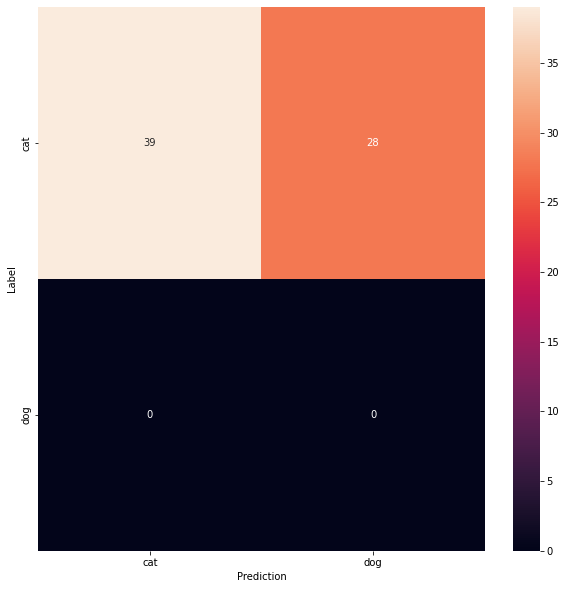

In [98]:
conf_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 10))
seaborn.heatmap(conf_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Preprocessing of the Data

In [4]:
import librosa
from IPython.display import Audio
import numpy as np

In [38]:
y, sr = librosa.load("cats_dogs/cat_4.wav")

# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

# Play back a 5-second excerpt with vocals
Audio(data=y[0:10*sr], rate=sr)

In [54]:
import os
for dirname, _, filenames in os.walk('cats_dogs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

cats_dogs\cat_1.wav
cats_dogs\cat_10.wav
cats_dogs\cat_100.wav
cats_dogs\cat_101.wav
cats_dogs\cat_102.wav
cats_dogs\cat_103.wav
cats_dogs\cat_105.wav
cats_dogs\cat_106.wav
cats_dogs\cat_107.wav
cats_dogs\cat_108.wav
cats_dogs\cat_109.wav
cats_dogs\cat_11.wav
cats_dogs\cat_110.wav
cats_dogs\cat_112.wav
cats_dogs\cat_113.wav
cats_dogs\cat_114.wav
cats_dogs\cat_115.wav
cats_dogs\cat_116.wav
cats_dogs\cat_117.wav
cats_dogs\cat_118.wav
cats_dogs\cat_119.wav
cats_dogs\cat_12.wav
cats_dogs\cat_120.wav
cats_dogs\cat_121.wav
cats_dogs\cat_122.wav
cats_dogs\cat_123.wav
cats_dogs\cat_124.wav
cats_dogs\cat_125.wav
cats_dogs\cat_126.wav
cats_dogs\cat_127.wav
cats_dogs\cat_128.wav
cats_dogs\cat_129.wav
cats_dogs\cat_13.wav
cats_dogs\cat_130.wav
cats_dogs\cat_131.wav
cats_dogs\cat_132.wav
cats_dogs\cat_133.wav
cats_dogs\cat_134.wav
cats_dogs\cat_135.wav
cats_dogs\cat_136.wav
cats_dogs\cat_137.wav
cats_dogs\cat_138.wav
cats_dogs\cat_139.wav
cats_dogs\cat_14.wav
cats_dogs\cat_140.wav
cats_dogs\cat_141